# Introduction to trackintel

This tutorial will show you the most important functionalities of trackintel.

## Model

Trackintel is based on a hierachical data model. 
![title](../docs/assets/hierarchy.png)

The details are explained in [readme.md](https://github.com/mie-lab/trackintel/blob/master/README.md)

To get started, import the framework using the following command. In addition it is always useful to import also pandas and geopandas.

In [19]:
import trackintel as ti
import geopandas as gpd
import pandas as pd
import numpy as np
import os

As a first step, the data that should be processed has to be importet. In this example we use a stored GEOJSON file, that contains raw positionfixes.

In [3]:
gdf = gpd.read_file('./data/pfs_tutorial.geojson')

This is the reccomended way to import data. Nevertheless it is also possible to read csv files directly using [read_positionfixes_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#csv-file-import).

The GeoDataFrame (gdf) imported by the GeoPandas read_file function is not yet in the correct format to be used by trackintel. If you try to call a trackintel function (e.g. plotting) on this GeoDataFrame, an error will occur. 

In [4]:
#gdf.as_positionfixes.plot()

gdf

,id,lat,lon,elevation,time,User,accuracy,geometry
0,0,39.984702,116.318417,149.9616,2008-10-23T02:53:04+00:00,0,None,POINT (116.31842 39.98470)
1,1,39.984683,116.318450,149.9616,2008-10-23T02:53:10+00:00,0,None,POINT (116.31845 39.98468)
2,2,39.984686,116.318417,149.9616,2008-10-23T02:53:15+00:00,0,None,POINT (116.31842 39.98469)
3,3,39.984688,116.318385,149.9616,2008-10-23T02:53:20+00:00,0,None,POINT (116.31839 39.98469)
4,4,39.984655,116.318263,149.9616,2008-10-23T02:53:25+00:00,0,None,POINT (116.31826 39.98465)
...,...,...,...,...,...,...,...,...
4236,4236,39.977904,116.327067,99.9744,2008-10-24T06:35:35+00:00,1,None,POINT (116.32707 39.97790)
4237,4237,39.977907,116.327066,99.9744,2008-10-24T06:35:40+00:00,1,None,POINT (116.32707 39.97791)
4238,4238,39.977900,116.327064,99.9744,2008-10-24T06:35:45+00:00,1,None,POINT (116.32706 39.97790)
4239,4239,39.977900,116.327064,99.9744,2008-10-24T06:35:48+00:00,1,None,POINT (116.32706 39.97790)


To transform the GeoDataFrame into the correct format use the function [positionfixes_from_gpd](https://trackintel.readthedocs.io/en/latest/modules/io.html#geodataframe-import). The method allows to rename the columns, define an index column and define a timezone. If no timezone is defined, UTC is assumed.

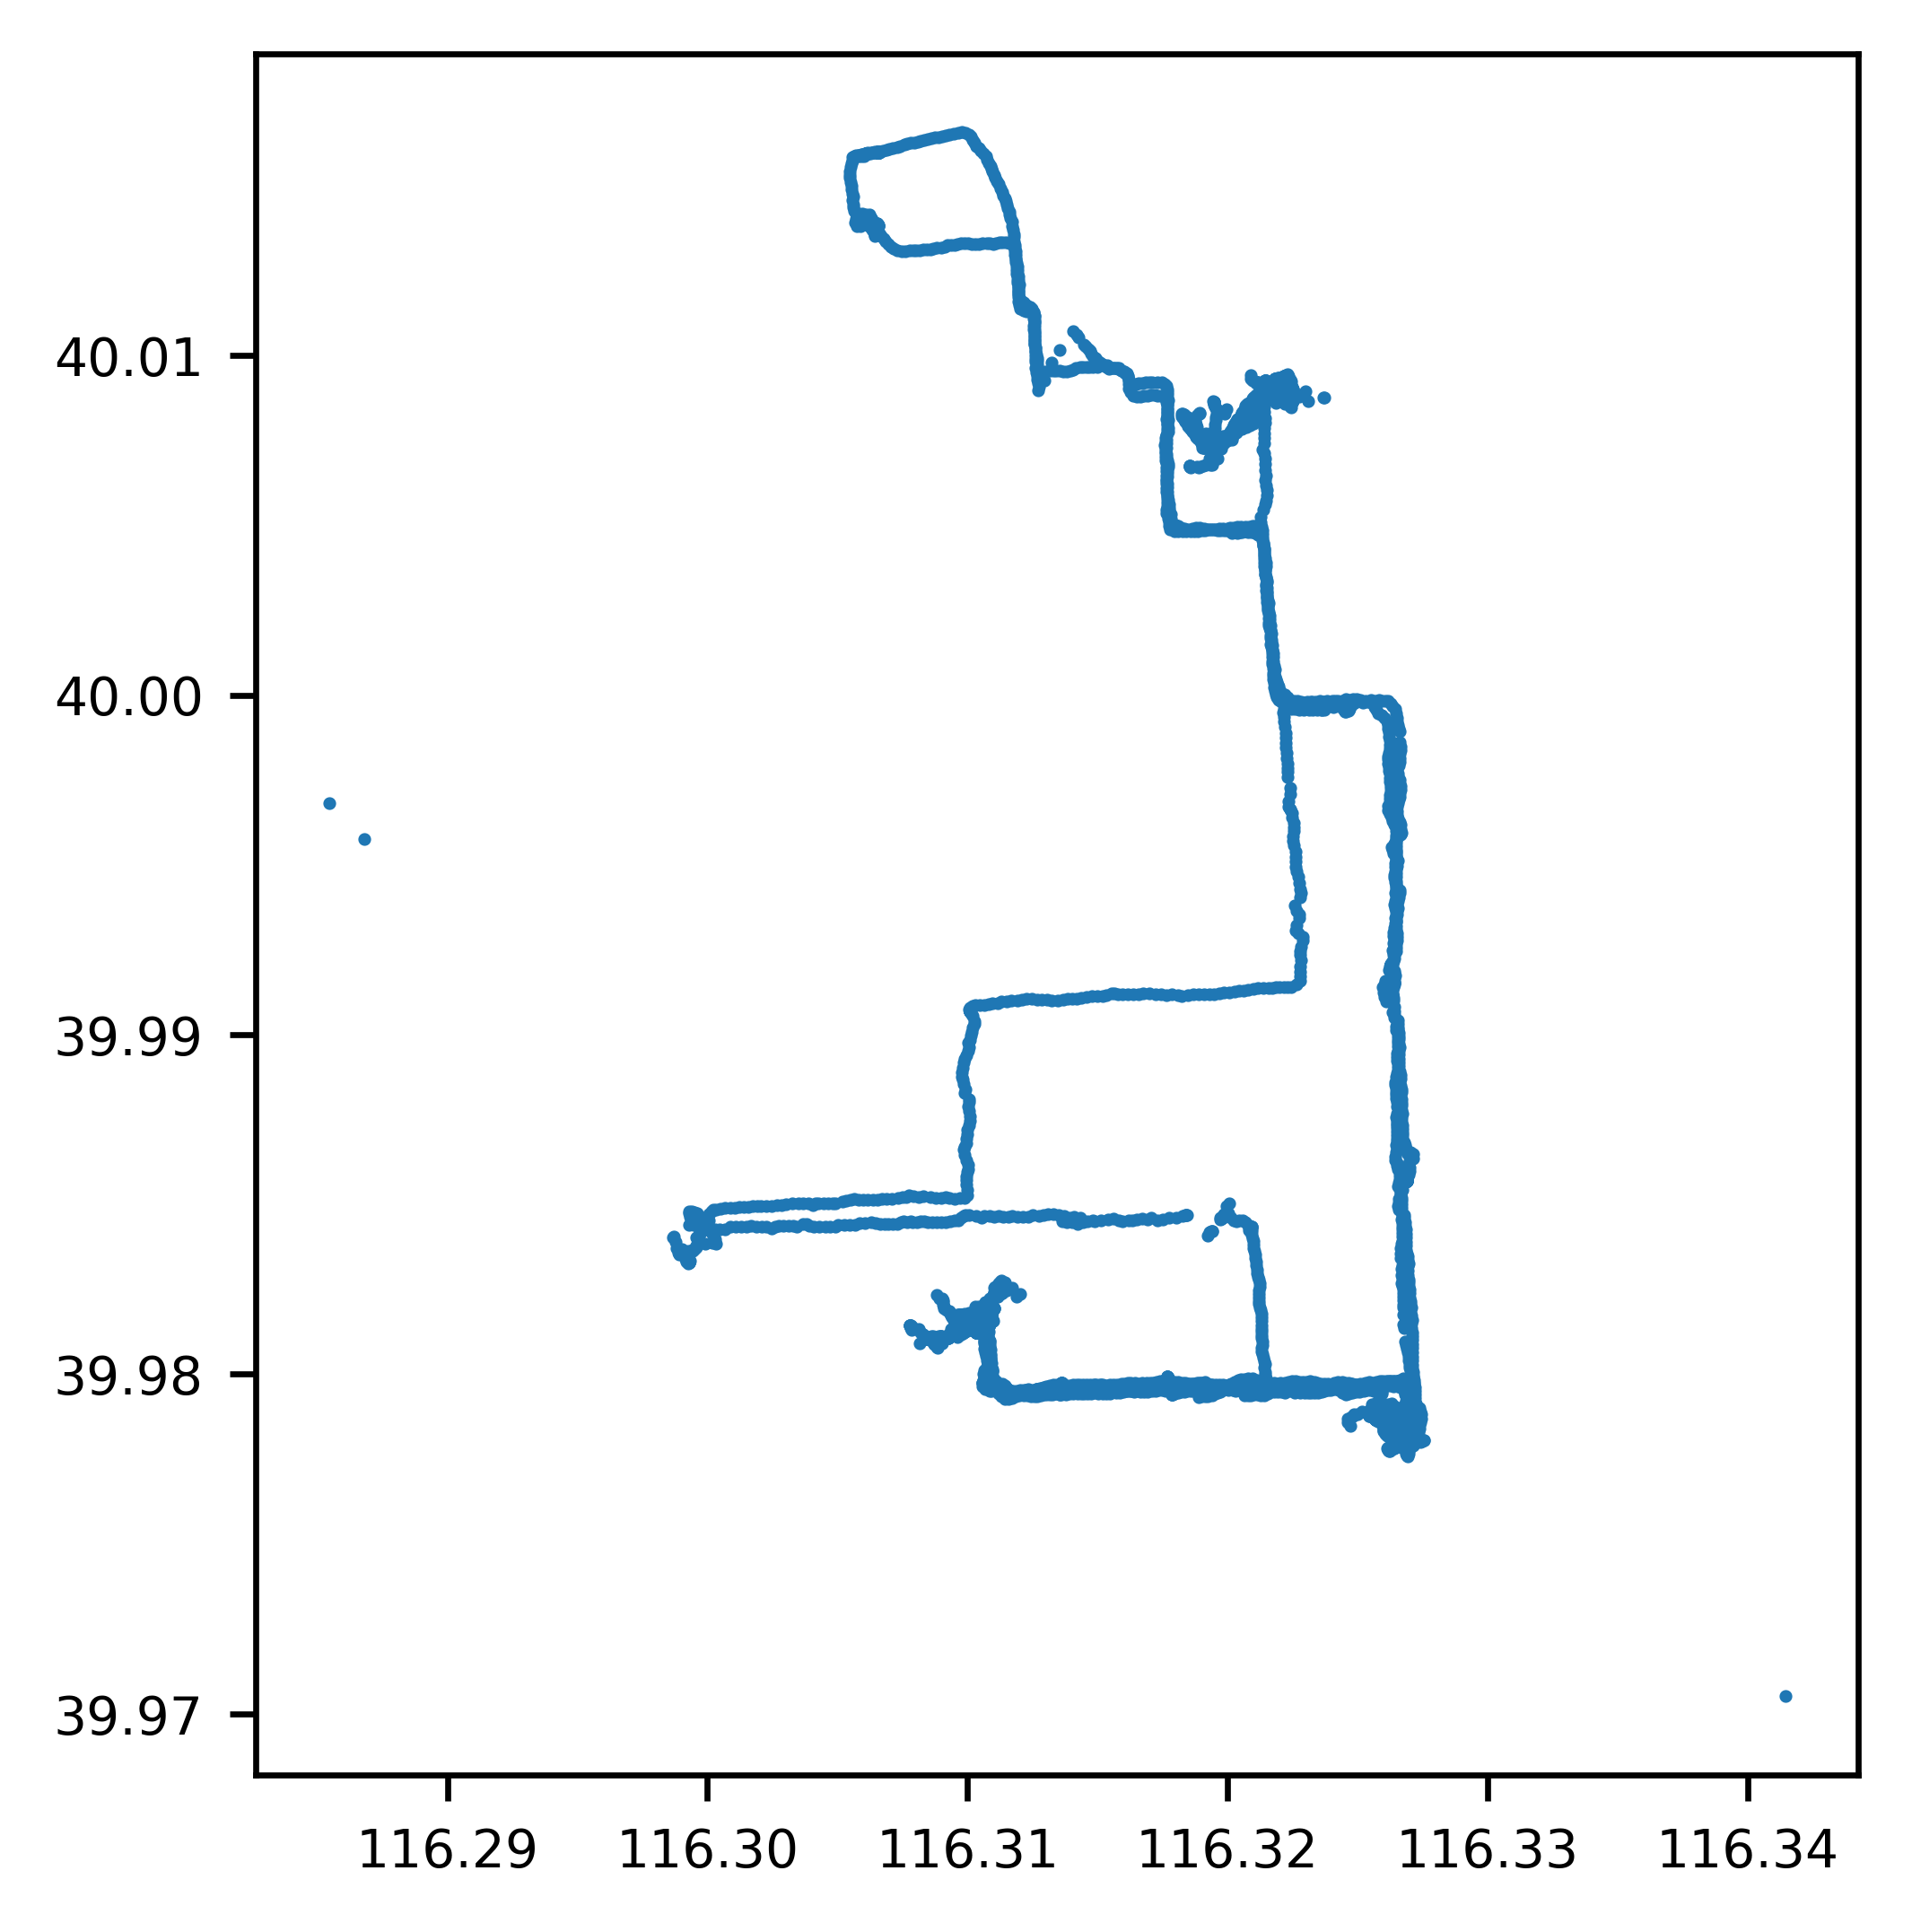

In [5]:
pfs = ti.io.from_geopandas.positionfixes_from_gpd(gdf, tz='UTC', 
                                                  mapper={'User':'user_id','time':'tracked_at', 'geometry':'geom'})
pfs.as_positionfixes.plot()

When the GeoDataFrame is once in the right format, all trackintel functions can be called using the accessor _as_positionfixes_ (as_triplegs, as_staypoints, ... for the other data types). In the next steps the staypoints and triplegs are generated.

In [6]:
pfs, stps = pfs.as_positionfixes.generate_staypoints(method='sliding', dist_threshold=25, time_threshold=5*60)

Each data type in the model has a plotting function. Let's vizualize the generated staypoints. To get a background map for bigger data sets, use plot_osm=True.

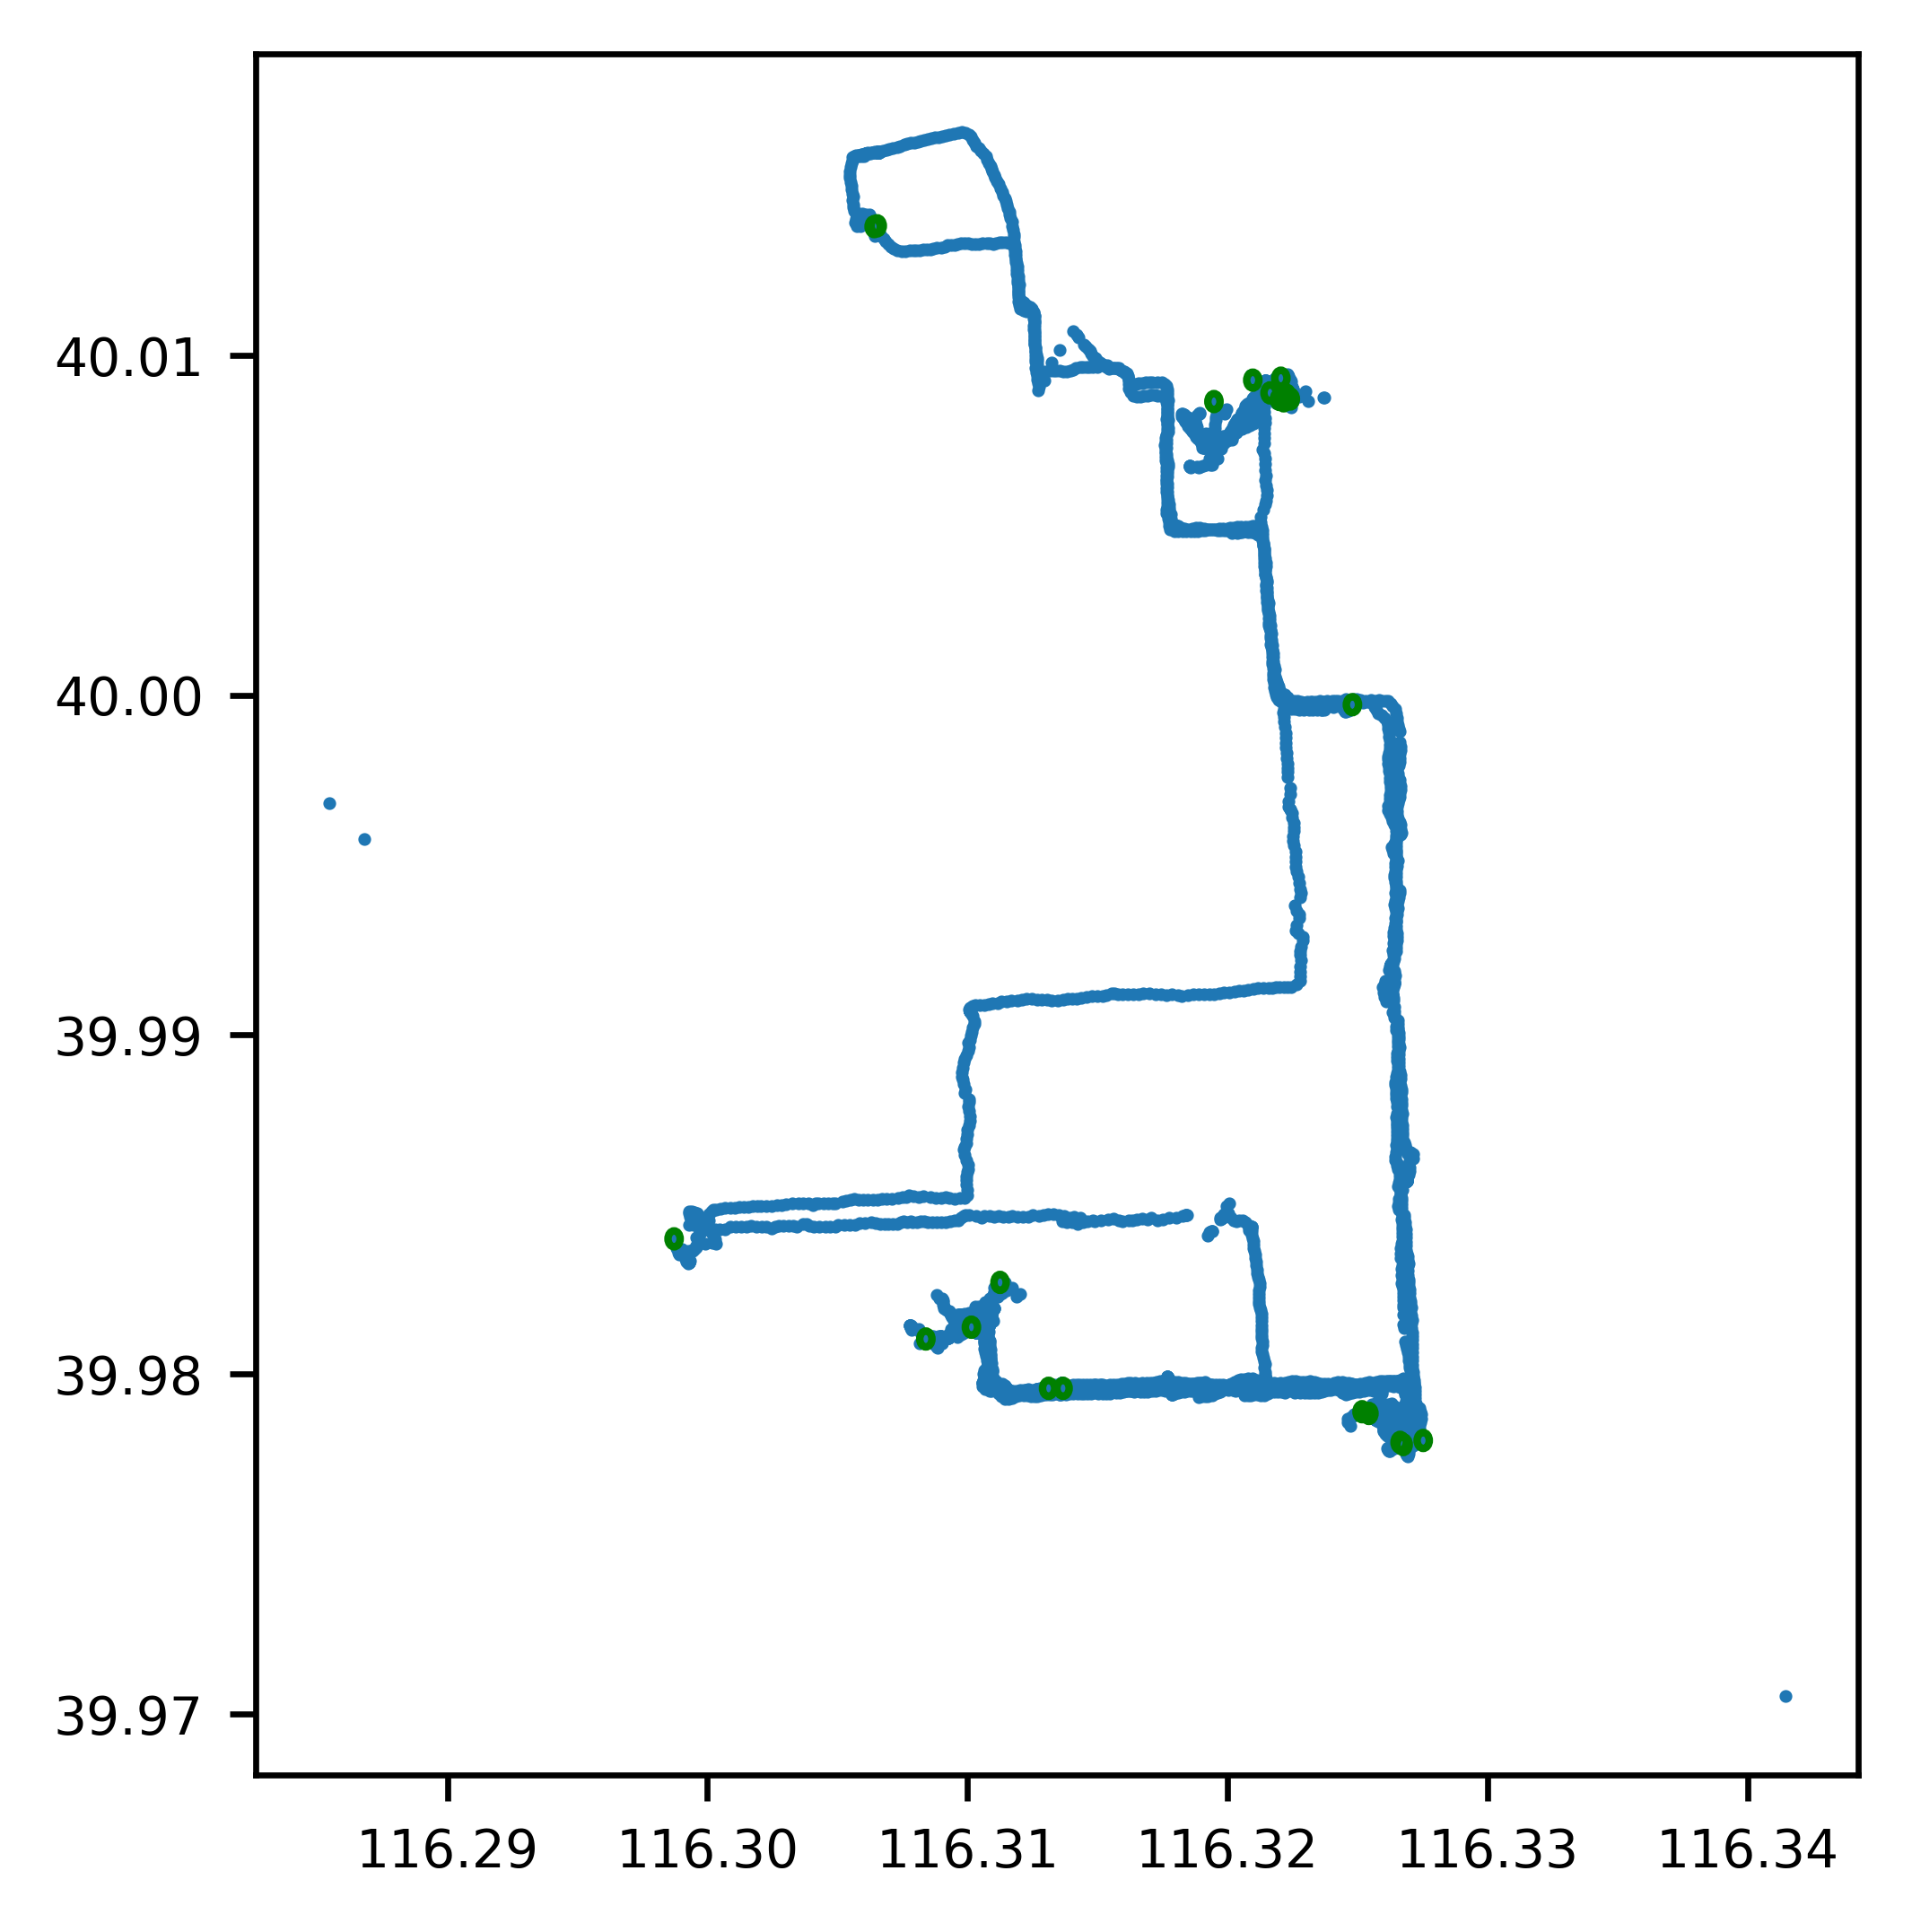

In [8]:
stps.as_staypoints.plot(positionfixes=pfs, radius=20)

In [9]:
pfs, tpls = pfs.as_positionfixes.generate_triplegs(stps, method='between_staypoints')

The generated staypoints and triplegs can be exported to csv files. Once stored, they can be re imported for further treatment.

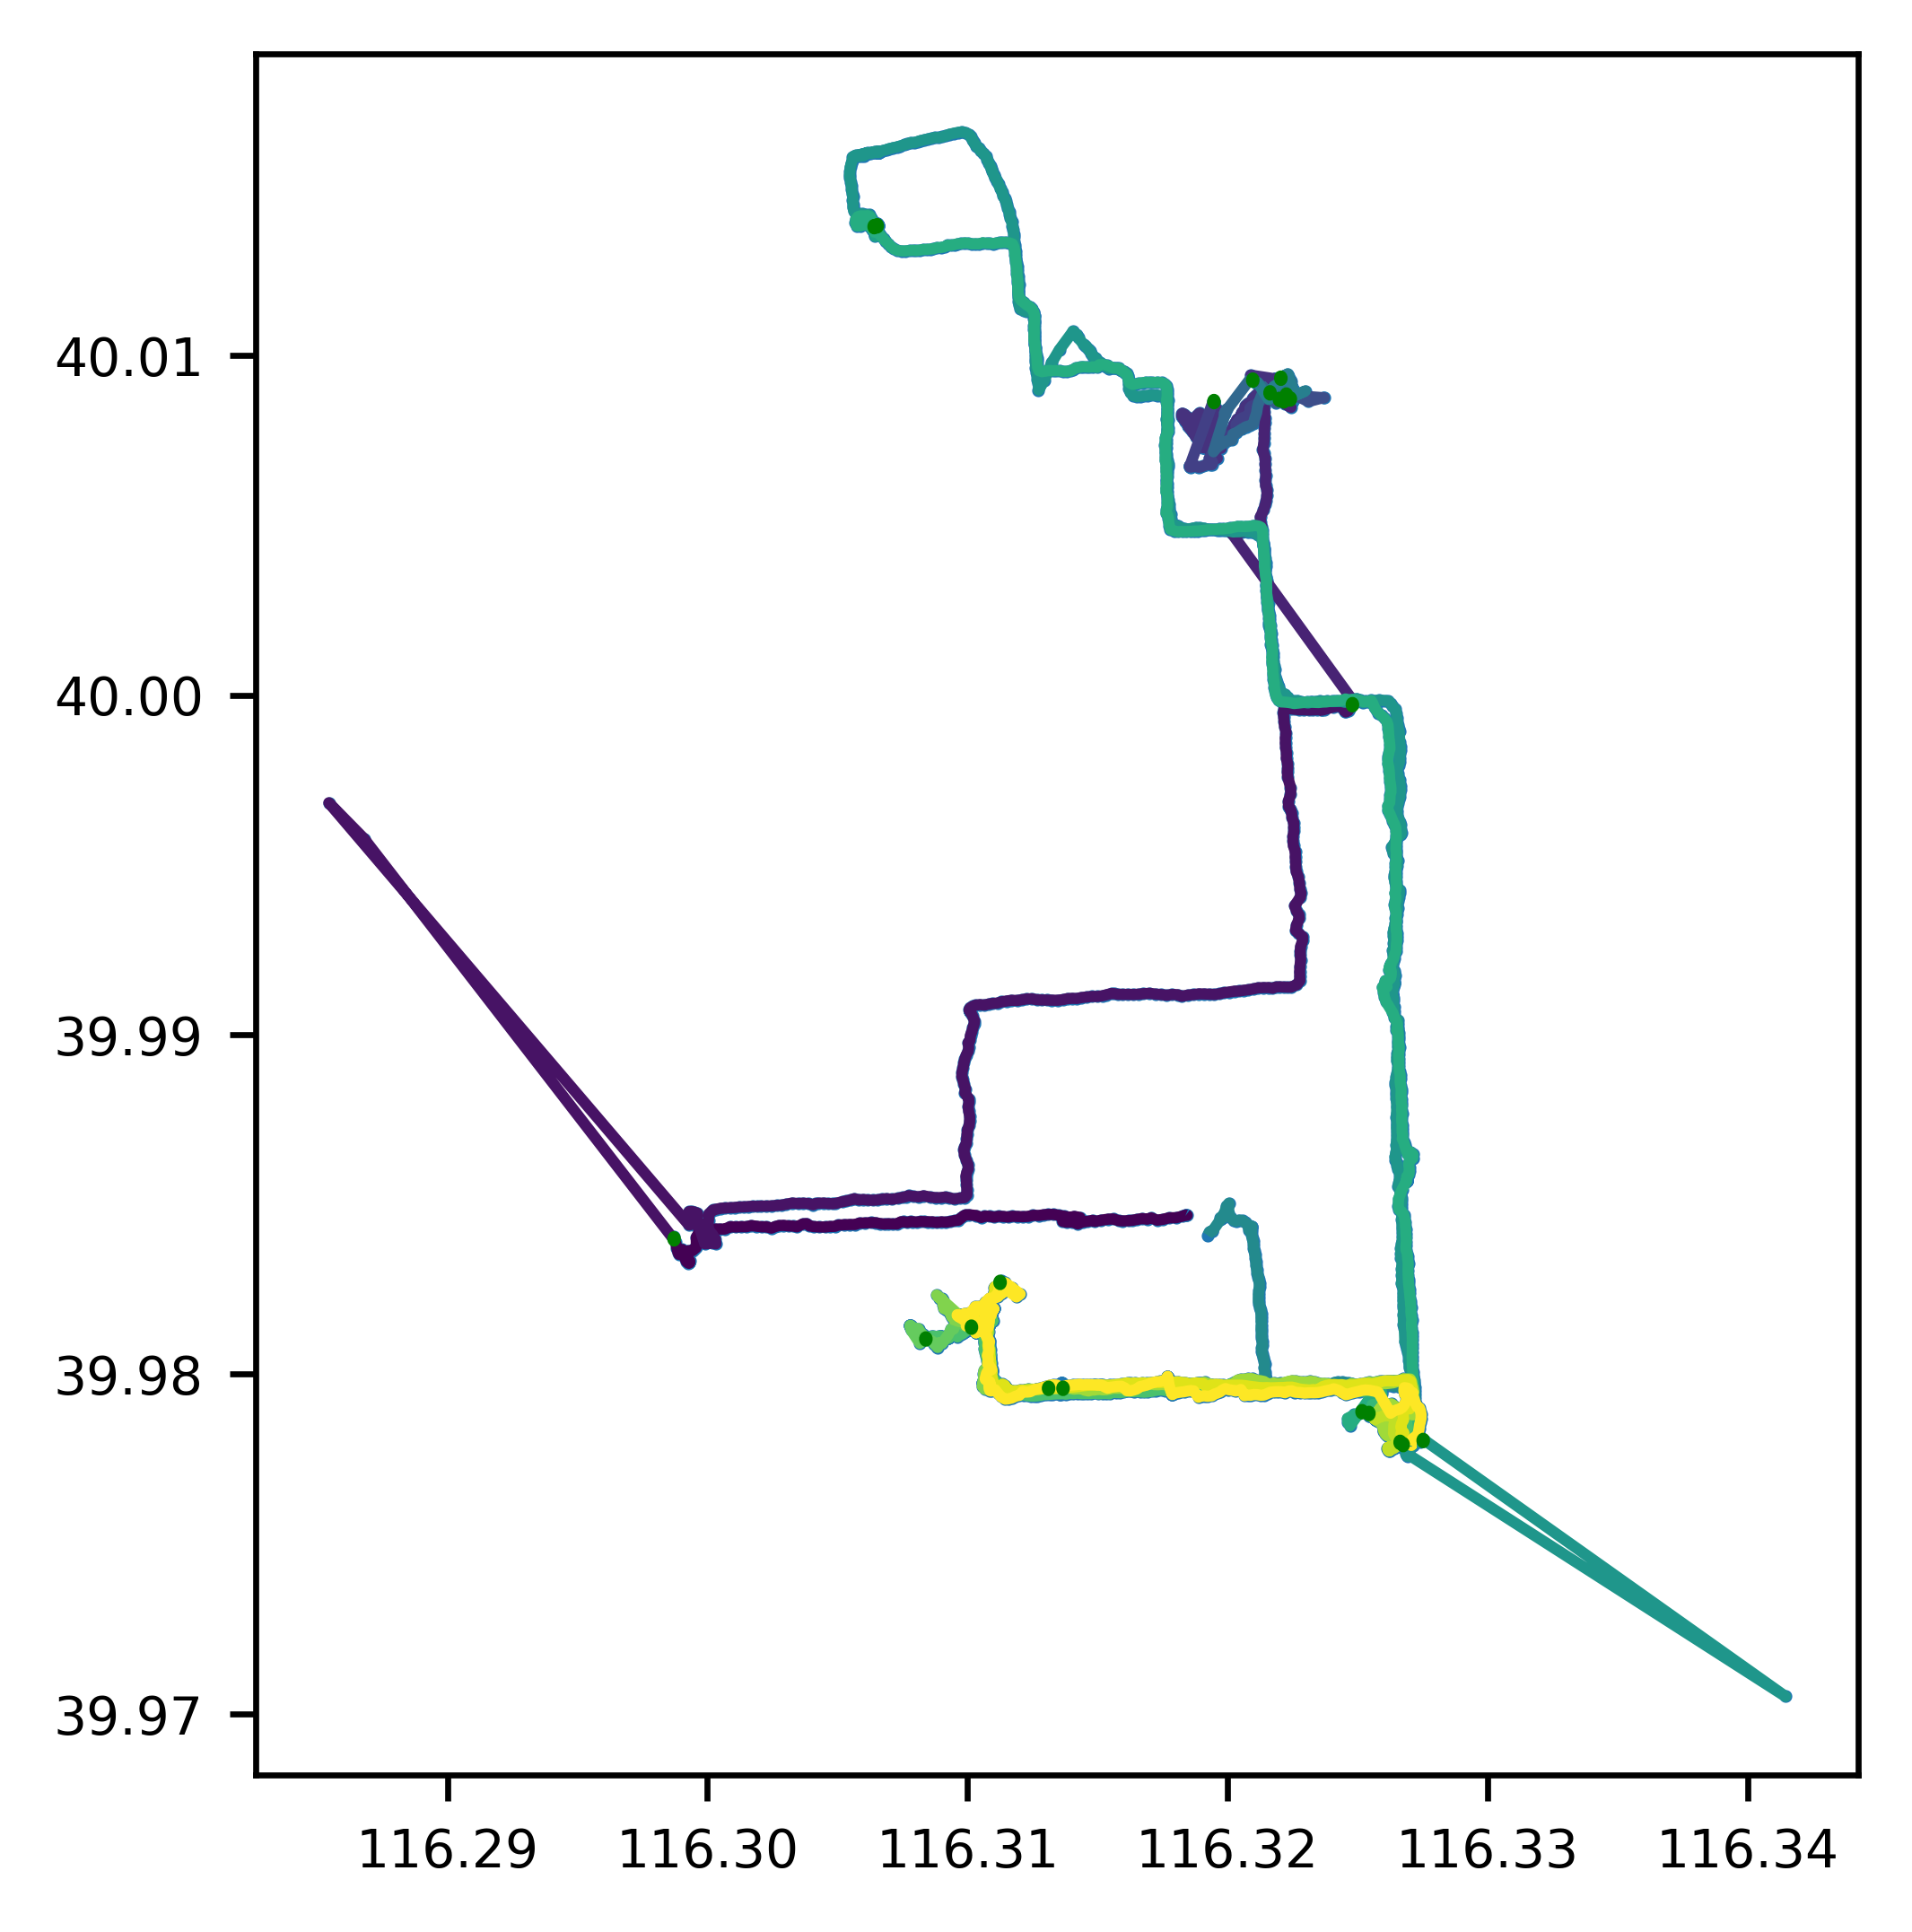

In [10]:
tpls.as_triplegs.plot(positionfixes=pfs,staypoints=stps, staypoints_radius=10)


The generated data can be exported as csv files and reused for further processing directly in trackintel or any other framework. Within python it is probably the easiest way just to keep the GeoDataFrames.

In [11]:
pfs.as_positionfixes.to_csv('./out/pfs_tutorial.csv')
stps.as_staypoints.to_csv('./out/stps_tutorial.csv')
tpls.as_triplegs.to_csv('./out/tpls_tutorial.csv')

To continue the analysis in a new script, the exported triplegs (or staypoints, positionfixes, ...) can be reimported directly from the csv file. This is done here for demonstration purposes. When reading csv files, it is important to specify the coordinate reference system (crs) with the EPSG code.

In [15]:
tpls = ti.read_triplegs_csv('./out/tpls_tutorial.csv', index_col=None, crs=4326)

A basic analysis functionality provided by trackintel is the [transport mode prediction](https://trackintel.readthedocs.io/en/latest/modules/analysis.html#transport-mode-identification). Per default it offers a split in to slow, motorized and fast mobility.

In [16]:
tpls.as_triplegs.predict_transport_mode()

The speed categories can also be defined individually by specifying the upper border of the interval corresponding to the category. For example:

In [23]:
tpls.as_triplegs.predict_transport_mode(categories={5/3.6:'cat1',10/3.6:'cat2',20/3.6:'cat3',np.inf:'cat4'})

,id,user_id,started_at,finished_at,geom,mode
0,0,0,2008-10-23 02:53:04+00:00,2008-10-23 03:05:05+00:00,"LINESTRING (116.31842 39.98470, 116.31845 39.9...",cat3
1,1,0,2008-10-23 03:05:15+00:00,2008-10-23 04:34:42+00:00,"LINESTRING (116.29866 39.98402, 116.28680 39.9...",cat2
2,2,0,2008-10-23 04:34:52+00:00,2008-10-23 09:55:31+00:00,"LINESTRING (116.32489 39.99977, 116.32016 40.0...",cat1
3,3,0,2008-10-23 10:02:29+00:00,2008-10-23 10:20:56+00:00,"LINESTRING (116.32185 40.00932, 116.32089 40.0...",cat2
4,4,0,2008-10-23 10:21:16+00:00,2008-10-23 10:32:35+00:00,"LINESTRING (116.31946 40.00867, 116.31855 40.0...",cat1
5,5,0,2008-10-23 10:33:20+00:00,2008-10-23 10:45:46+00:00,"LINESTRING (116.32230 40.00884, 116.32372 40.0...",cat1
6,6,0,2008-10-23 11:08:22+00:00,2008-10-23 11:11:02+00:00,"LINESTRING (116.32148 40.00885, 116.32186 40.0...",cat1
7,7,0,2008-10-23 11:11:12+00:00,2008-10-24 02:15:19+00:00,"LINESTRING (116.32089 40.00933, 116.31988 40.0...",cat1
8,8,0,2008-10-24 02:15:29+00:00,2008-10-24 02:22:49+00:00,"LINESTRING (116.32201 40.00870, 116.32205 40.0...",cat1
9,9,0,2008-10-24 02:29:26+00:00,2008-10-24 02:47:06+00:00,"LINESTRING (116.32216 40.00867, 116.32299 40.0...",cat1
